# Home assignment #1. Kalman Filter

Imagine a robot. Robot state is described with the following parameters

1. $x$, $y$ - robot coordinates,
2. $V_x$, $V_y$ - velocities.

We can only measure the coordinates of the robot, which should be reflected in the $ H $ matrix.

In this homework assignment:
- Fill in the matrices for the Kalman filter correctly.
- For all three experiments, visualize the dependence of $ x $, $ y $, $ V_x $, $ V_y $ over time.
- For all three experiments, visualize the dependence of each component of the gain matrix ($ K $) over time.
     - What does the dynamics of changes in its components say?
- How much does the velocity uncertainty decrease as a result of each experiment?

Below is a class that represents a matrix (as a mathematical object) and defines some standard operations for it.

In [ ]:
from math import *

class matrix:
    
    # implements basic operations of a matrix class
    
    def __init__(self, value):
        self.value = value
        self.dimx = len(value)
        self.dimy = len(value[0])
        if value == [[]]:
            self.dimx = 0
    
    def zero(self, dimx, dimy):
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise(ValueError, "Invalid size of matrix")
        else:
            self.dimx = dimx
            self.dimy = dimy
            self.value = [[0 for row in range(dimy)] for col in range(dimx)]
    
    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise(ValueError, "Invalid size of matrix")
        else:
            self.dimx = dim
            self.dimy = dim
            self.value = [[0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1
    
    def show(self):
        for i in range(self.dimx):
            print(self.value[i])
        print(' ')
    
    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimensions to add")
        else:
            # add if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res
    
    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimensions to subtract")
        else:
            # subtract if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res
    
    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise(ValueError, "Matrices must be m*n and n*p to multiply")
        else:
            # subtract if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
            return res
    
    def transpose(self):
        # compute transpose
        res = matrix([[]])
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res
    
    # Thanks to Ernesto E. Adorio for use of Cholesky and CholeskyInverse functions
    
    def Cholesky(self, ztol=1.0e-5):
        # Computes the upper triangular Cholesky factorization of
        # a positive definite matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise(ValueError, "Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(self.dimx)])
                if abs(S) < ztol:
                    S = 0.0
                res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
        return res
    
    def CholeskyInverse(self):
        # Computes inverse of matrix given its Cholesky upper Triangular
        # decomposition of matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/tjj**2 - S/tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = -sum([self.value[i][k]*res.value[k][j] for k in range(i+1, self.dimx)])/self.value[i][i]
        return res
    
    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res
    
    def __repr__(self):
        return repr(self.value)



In [ ]:

########################################

def filter(x, E):
    k = []
    X = []
    for n in range(len(measurements)):
        
        # prediction
        x = (F * x) + u
        E = F * E * F.transpose()

        # measurement update
        Z = matrix([measurements[n]])
        S = H * E * H.transpose() + R
        K = E * H.transpose() * S.inverse()
        k.append(K.value)
        x = x + (K * (Z.transpose() - (H * x)))
        
        E = (I - (K * H)) * E
    
        print('x= ')
        x.show()
        
        print('P= ')
        E.show()
        X.append(x.value)
        print('K= ')
        K.show()

    return X, k

########################################

In [ ]:
dt = 0.1
# initial uncertainty: 0. for positions x and y, 1000 for the two velocities
E = matrix([[0.,0.,0.,0.],[0.,0.,0.,0.],[0.,0.,1000.,0.],[0.,0.,0.,1000.]])
# next state function: 4D
F = matrix([[1.,0.,dt,0.],[0.,1.,0.,dt],[0.,0.,1.,0.],[0.,0.,0.,1.]])
# measurement function: reflect the fact that we observe x and y but not the two velocities
H =matrix([[1.,0.,0.,0.],[0.,1.,0.,0.]])
# measurement uncertainty: use 2x2 matrix with 0.1 as main diagonal
R = matrix([[0.1,0.],[0.,0.1]])
# 4D identity matrix
I = matrix([[]])
I.identity(4)

In [ ]:
print("### First Experiment ###")
measurements = [[5., 10.], [6., 8.], [7., 6.], [8., 4.], [9., 2.], [10., 0.]]
initial_xy = [4., 12.]

dt = 0.1

x = matrix([[initial_xy[0]], [initial_xy[1]], [0.], [0.]]) # initial robot state (location and velocity)
u = matrix([[0.], [0.1], [0.], [0.]]) # external motion applied to the robot

### First Experiment ###


In [ ]:
X, k = filter(x, E)

x= 
[4.99009900990099]
[10.02079207920792]
[9.900990099009901]
[-20.79207920792079]
 
P= 
[0.0990099009900991, 0.0, 0.990099009900991, 0.0]
[0.0, 0.0990099009900991, 0.0, 0.990099009900991]
[0.9900990099009874, 0.0, 9.90099009900996, 0.0]
[0.0, 0.9900990099009874, 0.0, 9.90099009900996]
 
K= 
[0.9900990099009901, 0.0]
[0.0, 0.9900990099009901]
[9.900990099009901, 0.0]
[0.0, 9.900990099009901]
 
x= 
[5.9960079840319365]
[8.008383233532934]
[9.980039920159681]
[-20.958083832335323]
 
P= 
[0.07984031936127742, 0.0, 0.3992015968063879, 0.0]
[0.0, 0.07984031936127742, 0.0, 0.3992015968063879]
[0.39920159680638734, 0.0, 1.9960079840319631, 0.0]
[0.0, 0.39920159680638734, 0.0, 1.9960079840319631]
 
K= 
[0.7984031936127748, 0.0]
[0.0, 0.7984031936127748]
[3.9920159680638747, 0.0]
[0.0, 3.9920159680638747]
 
x= 
[6.997858672376874]
[6.004496788008566]
[9.992862241256246]
[-20.98501070663811]
 
P= 
[0.06423982869379022, 0.0, 0.21413276231263487, 0.0]
[0.0, 0.06423982869379022, 0.0, 0.21413276231

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def visualize_k(k):
  t = [dt * i for i in range(1,len(measurements)+1)]
  K = np.array(k).T.squeeze()
  fig, axes = plt.subplots(4,2, figsize = (8,10))
  y_label = ["K" + str(i) + str(j) for i in range(4) for j in range(2)]
  for i in range(4):
    for j in range(2):
      axes[i, j].plot(t ,K[j][i],'ko--' , color = 'red')
      axes[i, j].set_xlabel('t')
      axes[i, j].set_ylabel(y_label[i*2 + j] , labelpad = 12 )
  plt.subplots_adjust(wspace = 0.4 ,hspace = 0.4)


In [ ]:
def visualize_X(X):
  t = [dt * i for i in range(1,len(measurements)+1)]
  X_arr = np.array(X).T.squeeze()
  print(X_arr[0])
  fig, axes = plt.subplots(2,2, figsize = (8,10))
  axes[0, 0].plot(t ,X_arr[0],'ko--' , color = 'green')
  axes[0, 0].set_xlabel('t')
  axes[0, 0].set_ylabel("X" , labelpad = 5) 
  axes[0, 1].plot(t ,X_arr[1],'ko--' , color = 'green')
  axes[0, 1].set_xlabel('t')
  axes[0, 1].set_ylabel("Y" , labelpad = 5 )
  axes[1, 0].plot(t ,X_arr[2],'ko--' , color = 'green')
  axes[1, 0].set_xlabel('t')
  axes[1, 0].set_ylabel("Vx" , labelpad = 5 )
  axes[1, 1].plot(t ,X_arr[3],'ko--' , color = 'green')
  axes[1, 1].set_xlabel('t')
  axes[1, 1].set_ylabel("Vy" , labelpad = 5 )
  plt.subplots_adjust(wspace = 0.4 ,hspace = 0.4)

Visualize the dependence of $ x $, $ y $, $ V_x $, $ V_y $ over time

[4.99009901 5.99600798 6.99785867 7.99866711 8.99909107 9.99934073]


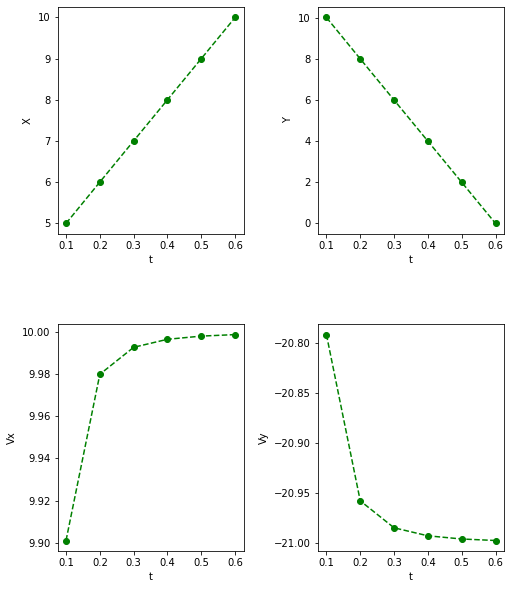

In [ ]:
visualize_X(X)

Visualize the components of the $ K $ matrix below

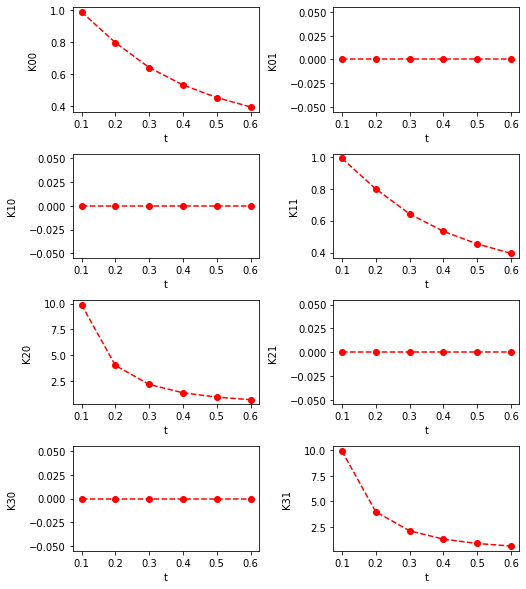

In [ ]:
visualize_k(k)

In [ ]:
print("### Second Experiment ###")
measurements = [[1., 4.], [6., 0.], [11., -4.], [16., -8.]]
initial_xy = [-4., 8.]

dt = 0.1

x = matrix([[initial_xy[0]], [initial_xy[1]], [0.], [0.]]) # initial robot state (location and velocity)
u = matrix([[0.], [0.1], [0.], [0.]]) # external motion applied to the robot

### Second Experiment ###


In [ ]:
X, k = filter(x, E)


x= 
[0.9504950495049505]
[4.04059405940594]
[49.504950495049506]
[-40.59405940594059]
 
P= 
[0.0990099009900991, 0.0, 0.990099009900991, 0.0]
[0.0, 0.0990099009900991, 0.0, 0.990099009900991]
[0.9900990099009874, 0.0, 9.90099009900996, 0.0]
[0.0, 0.9900990099009874, 0.0, 9.90099009900996]
 
K= 
[0.9900990099009901, 0.0]
[0.0, 0.9900990099009901]
[9.900990099009901, 0.0]
[0.0, 9.900990099009901]
 
x= 
[5.9800399201596806]
[0.016367265469061754]
[49.9001996007984]
[-40.918163672654686]
 
P= 
[0.07984031936127742, 0.0, 0.3992015968063879, 0.0]
[0.0, 0.07984031936127742, 0.0, 0.3992015968063879]
[0.39920159680638734, 0.0, 1.9960079840319631, 0.0]
[0.0, 0.39920159680638734, 0.0, 1.9960079840319631]
 
K= 
[0.7984031936127748, 0.0]
[0.0, 0.7984031936127748]
[3.9920159680638747, 0.0]
[0.0, 3.9920159680638747]
 
x= 
[10.989293361884368]
[-3.9912205567451817]
[49.964311206281224]
[-40.9707351891506]
 
P= 
[0.06423982869379022, 0.0, 0.21413276231263487, 0.0]
[0.0, 0.06423982869379022, 0.0, 0.2141

Visualize the dependence of $ x $, $ y $, $ V_x $, $ V_y $ over time

[ 0.95049505  5.98003992 10.98929336 15.99333555]


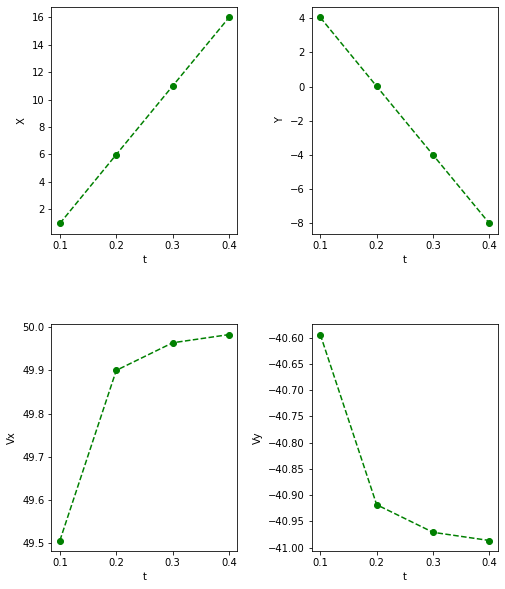

In [ ]:
visualize_X(X)

Visualize the components of the $ K $ matrix below

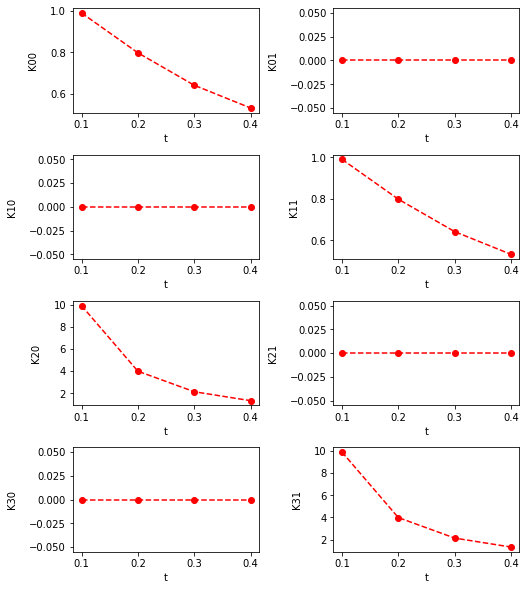

In [ ]:
visualize_k(k)

In [ ]:
print("### Third Experiment ###")
measurements = [[1., 17.], [1., 15.], [1., 13.], [1., 11.]]
initial_xy = [1., 19.]

dt = 0.1

x = matrix([[initial_xy[0]], [initial_xy[1]], [0.], [0.]]) # initial robot state (location and velocity)
u = matrix([[0.], [0.1], [0.], [0.]]) # external motion applied to the robot

### Third Experiment ###


In [ ]:
X, k =filter(x, E)


x= 
[1.0]
[17.020792079207922]
[0.0]
[-20.792079207920807]
 
P= 
[0.0990099009900991, 0.0, 0.990099009900991, 0.0]
[0.0, 0.0990099009900991, 0.0, 0.990099009900991]
[0.9900990099009874, 0.0, 9.90099009900996, 0.0]
[0.0, 0.9900990099009874, 0.0, 9.90099009900996]
 
K= 
[0.9900990099009901, 0.0]
[0.0, 0.9900990099009901]
[9.900990099009901, 0.0]
[0.0, 9.900990099009901]
 
x= 
[1.0]
[15.008383233532934]
[0.0]
[-20.95808383233534]
 
P= 
[0.07984031936127742, 0.0, 0.3992015968063879, 0.0]
[0.0, 0.07984031936127742, 0.0, 0.3992015968063879]
[0.39920159680638734, 0.0, 1.9960079840319631, 0.0]
[0.0, 0.39920159680638734, 0.0, 1.9960079840319631]
 
K= 
[0.7984031936127748, 0.0]
[0.0, 0.7984031936127748]
[3.9920159680638747, 0.0]
[0.0, 3.9920159680638747]
 
x= 
[1.0]
[13.004496788008565]
[0.0]
[-20.985010706638125]
 
P= 
[0.06423982869379022, 0.0, 0.21413276231263487, 0.0]
[0.0, 0.06423982869379022, 0.0, 0.21413276231263487]
[0.21413276231263462, 0.0, 0.7137758743754614, 0.0]
[0.0, 0.214132762312

Visualize the dependence of $ x $, $ y $, $ V_x $, $ V_y $ over time

[1. 1. 1. 1.]


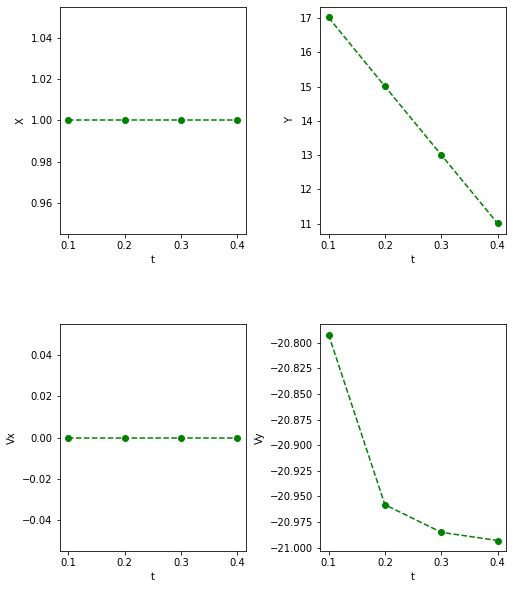

In [ ]:
visualize_X(X)

Visualize the components of the $ K $ matrix below

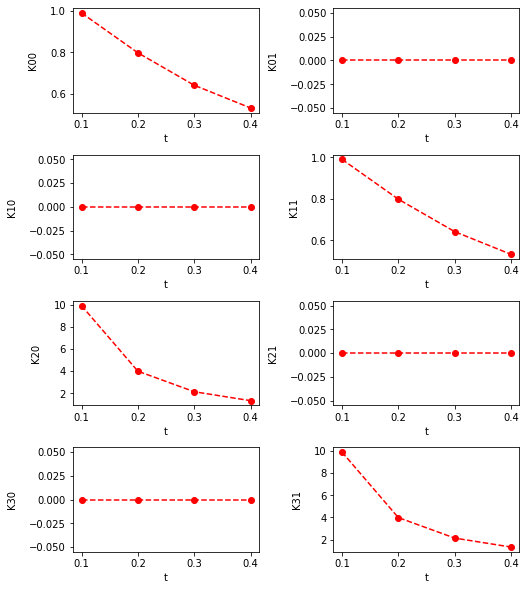

In [ ]:
visualize_k(k)